### Problemm Statement 

**The goal of the project is to classify the movie reviews as either positive or negative. We would be working on the ‘movie_reviews’ dataset in Kaggle**

### import important libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import ngrams
import unicodedata, string,re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings,os
warnings.filterwarnings('ignore')

### Load the dataset 

In [2]:
train_set = pd.read_csv("/Users/kouamengoran/Desktop/train.tsv", sep='\t')
test_set = pd.read_csv("/Users/kouamengoran/Desktop/test.tsv", sep='\t')

<p><strong>Check the five first  row of the train and test dataset</strong></p>

train_set.head()

In [3]:
test_set.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [4]:
#  Check the shape of the data 
train_set.shape , test_set.shape

((156060, 4), (66292, 3))

<p> The train set has  <strong>156060 observations and 4 columns. </strong></p>
<p> The test set has <strong>66292 robservations and 3 columns.</strong></p>

In [5]:
# trainset and test set columns 
train_set.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [6]:
test_set.columns

Index(['PhraseId', 'SentenceId', 'Phrase'], dtype='object')

In [7]:
# information about the DataFrame including the index dtype and column dtypes
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [8]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66292 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [9]:
# check the summary statistics 
train_set.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [10]:
test_set.describe()

,PhraseId,SentenceId
count,66292.00000,66292.000000
mean,189206.50000,10114.909144
std,19136.99636,966.787807
min,156061.00000,8545.000000
25%,172633.75000,9266.000000
50%,189206.50000,10086.000000
75%,205779.25000,10941.000000
max,222352.00000,11855.000000


In [11]:
train_set.describe(include= ['object'])

,Phrase
count,156060
unique,156060
top,know whodunit
freq,1


In [12]:
test_set.describe(include= ['object'])

,Phrase
count,66292
unique,66292
top,knows few continental divides
freq,1


In [13]:
# Check the variable Phrase 
train_set['Phrase'].head()

0    A series of escapades demonstrating the adage ...
1    A series of escapades demonstrating the adage ...
2                                             A series
3                                                    A
4                                               series
Name: Phrase, dtype: object

In [14]:
# Create sentiment class using the sentiment  numeric values
train_set['sentiment_class'] = train_set['Sentiment'].map({0:'negative',1:'somewhat negative',2:'neutral',3:'somewhat positive',4:'positive'})
train_set.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


### Pre-processing 

In [15]:
# define a helper to remonve all non ascii words 
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

#### Define an helper function to  lower all characters 

In [16]:
# concert all characters to lowers 
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


#### Define  an helper function to remove all punctuation 

In [17]:

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

#### Define an helper function to remove  all numbers 

In [18]:
# Remove  all numbers 

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words


#### Stem _words 

In [19]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems


#### Lemmatize  words 

In [20]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

#### define a noemalize function that combine: remove _ascii, to_lowercase, reove _punction, remove number function 

In [21]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    return words

#### Remove  English stopwords 

In [22]:
stop_words=stopwords.words('english')
train_set['Phrase']=train_set['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


#### Remove words with less than 2 characters

In [23]:
def words_with_more_than_three_chars(text):
    return " ".join([t for t in text.split() if len(t)>3])
train_set['Phrase']=train_set['Phrase'].apply(lambda x:words_with_more_than_three_chars(x))


In [24]:
train_set.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative
1,2,1,series escapades demonstrating adage good goose,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


In [25]:
train_set.groupby('Sentiment')['Sentiment'].count()

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
Name: Sentiment, dtype: int64

In [73]:
# find the pourcentage of each values 
round(train_set.sentiment_class.value_counts(normalize= True),3)

neutral              0.510
somewhat positive    0.211
somewhat negative    0.175
positive             0.059
negative             0.045
Name: sentiment_class, dtype: float64

In [27]:
s= round(train_set.sentiment_class.value_counts(normalize=True),2)

<AxesSubplot:ylabel='sentiment_class'>

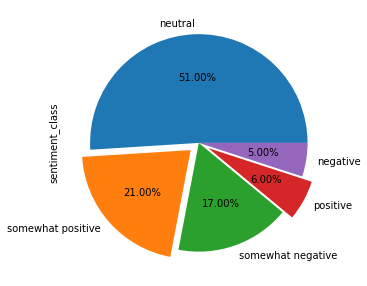

In [28]:
s.plot.pie(figsize=(5,5),explode=[0,0.1,0,0.1,0], autopct='%.2f%%')

In [29]:
# Check the length of ecah sentence 

In [30]:
train_set['PhraseLength']=train_set['Phrase'].apply(lambda x: len(x))

In [31]:
train_set.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative,108
1,2,1,series escapades demonstrating adage good goose,2,neutral,47
2,3,1,series,2,neutral,6
3,4,1,,2,neutral,0
4,5,1,series,2,neutral,6


In [32]:
train_set.sort_values(by='PhraseLength', ascending=False).head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength
105155,105156,5555,spiced humor -LRB- speak fluent flatula advise...,3,somewhat positive,210
62500,62501,3162,While transgressive trappings -LRB- especially...,1,somewhat negative,210
54876,54877,2734,Filmmakers Dana Janklowicz-Mann Amir Mann area...,3,somewhat positive,208
26148,26149,1199,movie biggest shocks come seeing former nymphe...,1,somewhat negative,202
43802,43803,2124,-LRB- City -RRB- reminds realistically nuanced...,3,somewhat positive,202


In [33]:
####

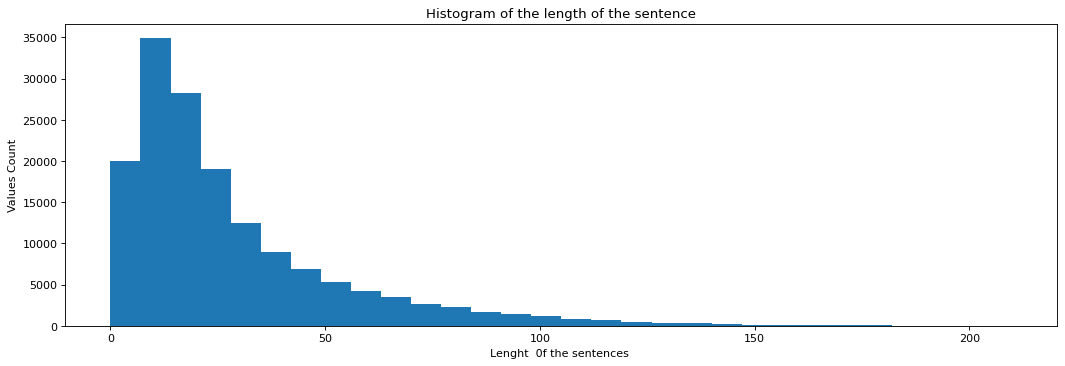

In [34]:
from matplotlib.pyplot import figure
figure(figsize=(16, 5), dpi=80)
plt.hist(train_set["PhraseLength"] , bins = 30)
plt.xlabel("Lenght  0f the sentences ")
plt.ylabel("Values Count")
plt.title("Histogram of the length of the sentence")          
plt.show()

In [35]:
round(train_set['PhraseLength'].describe(),0)

count    156060.0
mean         28.0
std          26.0
min           0.0
25%          10.0
50%          19.0
75%          36.0
max         210.0
Name: PhraseLength, dtype: float64

#### Display the wordcloud

In [36]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 

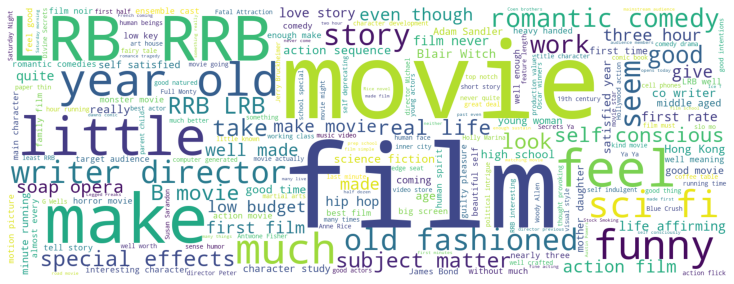

In [37]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 
word_cloud_common_words=[]  
for index, row in train_set.iterrows(): 
    word_cloud_common_words.append((row['Phrase'])) 
word_cloud_common_words

wordcloud = WordCloud(width = 1600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 5).generate(''.join(word_cloud_common_words)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

#### the most frequent words 

In [38]:
text_list=[]  
for index, row in train_set.iterrows(): 
    text_list.append((row['Phrase'])) 
text_list

total_words=''.join(text_list)
total_words=word_tokenize(total_words)

In [39]:
freq_words=FreqDist(total_words)
word_frequency=FreqDist(freq_words)

In [40]:
# print the fifteen most common  words 
print(word_frequency.most_common(15))

[('film', 3271), ('movie', 2894), ('like', 1985), ('-RRB-', 1372), ('-LRB-', 1370), ('story', 1207), ('much', 1089), ('good', 1070), ('even', 1042), ('characters', 1000), ('little', 983), ('make', 838), ('comedy', 797), ('funny', 767), ('enough', 745)]


<AxesSubplot:>

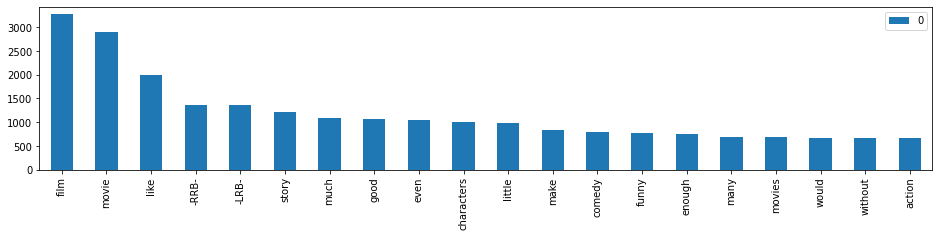

In [41]:
pd.DataFrame(word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,3),grid=False)

#### frequent words for negative comments

In [42]:
neg_text_list=[]  
for index, row in train_set[train_set['Sentiment']==0].iterrows(): 
    neg_text_list.append((row['Phrase'])) 
neg_text_list

neg_total_words=' '.join(neg_text_list)
neg_total_words=word_tokenize(neg_total_words)

neg_freq_words=FreqDist(neg_total_words)
neg_word_frequency=FreqDist(neg_freq_words)

<AxesSubplot:>

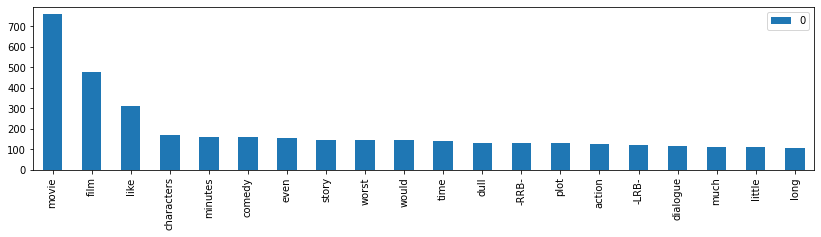

In [43]:
pd.DataFrame(neg_word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(14,3),grid=False)

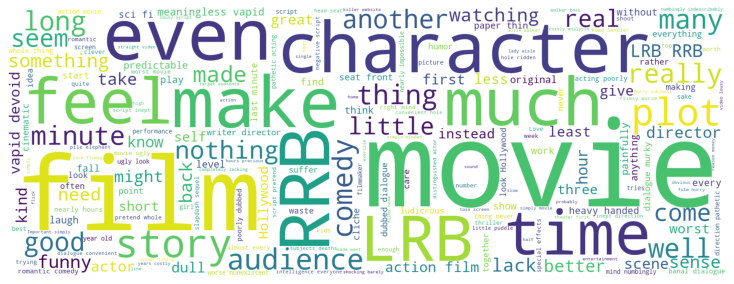

In [44]:
word_cloud_common_words=[]  
for index, row in train_set[train_set['Sentiment']==0].iterrows(): 
    word_cloud_common_words.append((row['Phrase'])) 
word_cloud_common_words

wordcloud = WordCloud(width = 1600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 5).generate(''.join(word_cloud_common_words)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

#### frequent words for positives sentenses

In [45]:
pos_text_list=[]  
for index, row in train_set[train_set['Sentiment']==4].iterrows(): 
    pos_text_list.append((row['Phrase'])) 
pos_text_list

pos_total_words=' '.join(pos_text_list)
pos_total_words=word_tokenize(pos_total_words)

pos_freq_words=FreqDist(pos_total_words)
pos_word_frequency=FreqDist(pos_freq_words)

<AxesSubplot:>

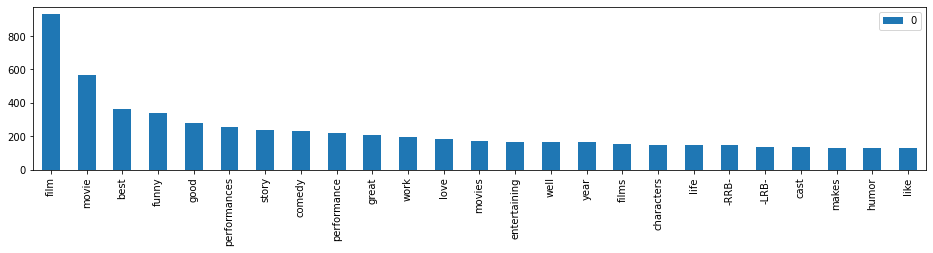

In [46]:
pd.DataFrame(pos_word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(25).plot(kind='bar',figsize=(16,3),grid=False)

##### Frequent word for neutral Sentiment 

In [47]:
neutral_text_list=[]  
for index, row in train_set[train_set['Sentiment']==2].iterrows(): 
    neutral_text_list.append((row['Phrase'])) 
neutral_text_list

neutral_total_words=' '.join(neutral_text_list)
neutral_total_words=word_tokenize(neutral_total_words)

neutral_freq_words=FreqDist(neutral_total_words)
neutral_word_frequency=FreqDist(neutral_freq_words)

<AxesSubplot:>

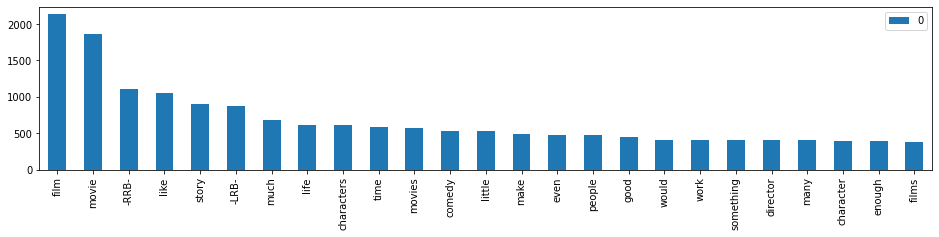

In [48]:
pd.DataFrame(neutral_word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(25).plot(kind='bar',figsize=(16,3),grid=False)

#### Common bigram words used for positive sentiment

In [49]:
text_list=[]  
for index, row in train_set.iterrows(): 
    text_list.append((row['Phrase'])) 
text_list

total_words=' '.join(text_list)
total_words=word_tokenize(total_words)

freq_words=FreqDist(total_words)
word_frequency=FreqDist(ngrams(freq_words,2))
word_frequency.most_common()[0:10]

[(('series', 'escapades'), 1),
 (('escapades', 'demonstrating'), 1),
 (('demonstrating', 'adage'), 1),
 (('adage', 'good'), 1),
 (('good', 'goose'), 1),
 (('goose', 'also'), 1),
 (('also', 'gander'), 1),
 (('gander', 'occasionally'), 1),
 (('occasionally', 'amuses'), 1),
 (('amuses', 'none'), 1)]

<AxesSubplot:>

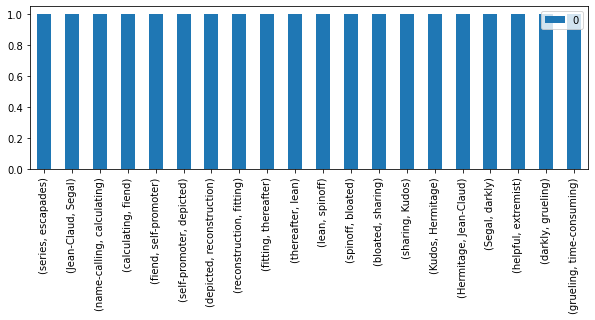

In [50]:
# visualize 
pd.DataFrame(word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(10,3),grid= False)

<p>In thefollowing step we will prepare our data  for prediction. 
We need to <strong> tokenize </strong> the sentences of the Phrase variable</p> 


<p> <strong>We need  to create a bag of words</strong></p>

In [51]:
train_set['tokenized_words']=train_set['Phrase'].apply(lambda x:word_tokenize(x))
train_set.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength,tokenized_words
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative,108,"[series, escapades, demonstrating, adage, good..."
1,2,1,series escapades demonstrating adage good goose,2,neutral,47,"[series, escapades, demonstrating, adage, good..."
2,3,1,series,2,neutral,6,[series]
3,4,1,,2,neutral,0,[]
4,5,1,series,2,neutral,6,[series]


<p><strong> Create countVectorizer</strong></p>

In [52]:
count_vectorizer=CountVectorizer()
phrase_dt=count_vectorizer.fit_transform(train_set['Phrase'])

In [53]:
phrase_dt.shape

(156060, 14843)

<p><strong>Split the data set in train and  test set</strong></p> 

In [54]:
X_train,X_val,y_train,y_val=train_test_split(phrase_dt,train_set['Sentiment'],test_size=0.3, random_state=38)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((109242, 14843), (109242,), (46818, 14843), (46818,))

<p><strong> The First Model</strong></p>

In [55]:
# Extenciate the model 
Lrg =LogisticRegression()

In [56]:
# fit the model  with the  train set 
Lrg.fit(X_train,y_train)

LogisticRegression()

In [57]:
round(accuracy_score(Lrg.predict(X_val),y_val)*100,3)

63.736

In [58]:
# Preparing data with tf-idf

In [59]:
tfidf= TfidfVectorizer()
tfidf_dt=tfidf.fit_transform(train_set['Phrase'])

In [60]:
X_train,X_val,y_train,y_val=train_test_split(tfidf_dt,train_set['Sentiment'],test_size=0.3, random_state=38)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((109242, 14843), (109242,), (46818, 14843), (46818,))

In [61]:
tfidf_model=LogisticRegression()

In [62]:
tfidf_model.fit(X_train,y_train)

LogisticRegression()

In [63]:
round(accuracy_score(tfidf_model.predict(X_val),y_val)*100, 3)

62.275

In [64]:
print(tfidf_model.predict(X_val)[0:10])

[3 2 2 2 3 3 2 3 2 3]


In [65]:
test_set.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [66]:
def words_with_more_than_three_chars(text):
    return " ".join([t for t in text.split() if len(t)>3])
test_set['Phrase']=test_set['Phrase'].apply(lambda x:words_with_more_than_three_chars(x))

In [67]:
#test_set['Phrase']=test_set['Phrase'].apply(lambda x:remove_punctuation(x))

In [68]:
test_set.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,intermittently pleasing mostly routine effort
1,156062,8545,intermittently pleasing mostly routine effort
2,156063,8545,
3,156064,8545,intermittently pleasing mostly routine effort
4,156065,8545,intermittently pleasing mostly routine


In [69]:
test_set['Phrase']=test_set['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_dtm=tfidf.transform(test_set['Phrase'])

In [70]:
def predict_new_text(text):
    tfidf_text=tfidf.transform([text])
    return tfidf_model.predict(tfidf_text)

In [71]:
test_set.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,intermittently pleasing mostly routine effort
1,156062,8545,intermittently pleasing mostly routine effort
2,156063,8545,
3,156064,8545,intermittently pleasing mostly routine effort
4,156065,8545,intermittently pleasing mostly routine


In [72]:
test_set['Sentiment']=tfidf_model.predict(test_dtm)
test_set.set_index=test_set['PhraseId']
test_set.sort_values(by= 'Sentiment', ascending =True).head(50)

,PhraseId,SentenceId,Phrase,Sentiment
14966,171027,9188,worst thing Soderbergh ever done,0
14962,171023,9188,could worst thing Soderbergh ever done,0
14961,171022,9188,could worst thing Soderbergh ever done,0
42945,199006,10584,failure life,0
42944,199005,10584,failure life,0
42943,199004,10584,failure life,0
14953,171014,9188,Given heavy-handed portent-heavy could worst t...,0
35710,191771,10210,dull,0
55791,211852,11273,not-great movie,0
55790,211851,11273,not-great movie,0
